# Extracting for a single year

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_83313/2110789082.py:45: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.46623 39.75030, -75.46630 39.750...                 44477   
1   MULTIPOLYGON (((-75.56120 39.65815, -75.56097 ...                 41343   
2   POLYGON ((-75.60468 39.71253, -75.60419 39.712...                 39367   
3   POLYGON ((-75.72416 39.74084, -75.72413 39.740...                 40479   
4   POLYGON ((-75.54971 39.81362, -75.54964 39.814...                 40613   
5   POLYGON ((-75.36798 38.70089, -75.36787 38.701...                 53772   
6   POLYGON ((-75.67979 39.74953, -75.67974 39.749...                 42058   
7   POLYGON ((-75.78892 39.66461, -75.78892 39.664...                 45333   
8   POLYGON ((-75.73867 39.67054, -75.73842 39.671...                 41935   
9   POLYGON ((-75.78323 39.65329, -75.78220 39.654...                 45317   
10  POLYGON ((-75.73888 39.66940, -75.73886 39.669...                 42726   
11  MULTIPOLYGON (((-75.74340 39.60527, -75.74288 ..

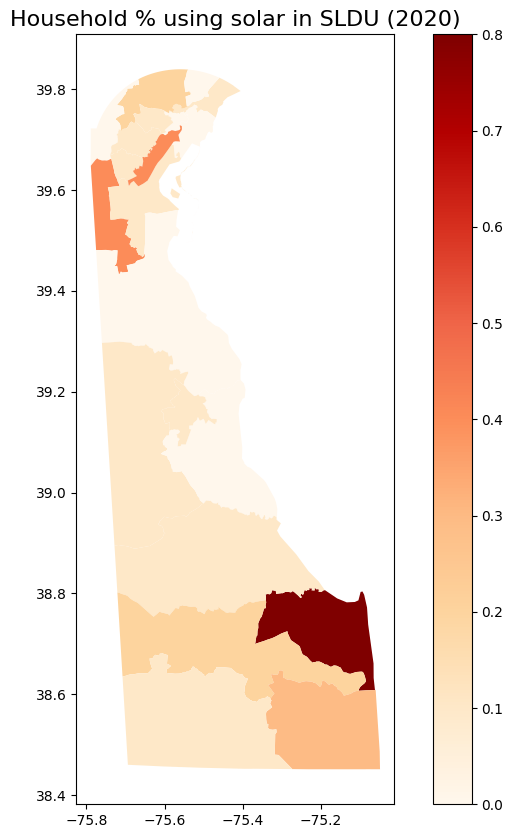

In [1]:
import requests
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load the Delaware dry land shapefile as a GeoDataFrame
USmap = gpd.read_file("/Users/kamran/Downloads/Shapefiles/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

year = '2020'

usr_key = os.environ.get('CENSUS_API_KEY')

host = 'https://api.census.gov/data'
dataset_acronym = '/acs/acs5'
g = '?get='
variables = 'NAME,B01001_001E,B25040_001E,B25040_008E'
location = '&for=state%20legislative%20district%20(upper%20chamber):*&in=state:10'

# Put it all together in one f-string:
query_url = f"{host}/{year}{dataset_acronym}{g}{variables}{location}&key={usr_key}"

response = requests.get(query_url)

# Create shapefile query URL
shape_url = f"https://www2.census.gov/geo/tiger/TIGER{year}/SLDU/tl_{year}_10_sldu.zip"

# Read the shapefile from the URL into a GeoPandas DataFrame
sldu_gdf = gpd.read_file(shape_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    
    # Convert the JSON response to a list of lists (excluding the header)
    data = response.json()[1:]
    
    # Convert the list of lists into a DataFrame
    columns = response.json()[0]  # Use the first row as column names
    api_data_df = pd.DataFrame(data, columns=columns)
    api_data_df = api_data_df.astype({'B25040_001E':'int64','B25040_008E':'int64'}) #.apply(pd.to_numeric, errors='ignore')
    api_data_df['Percentage of households using solar energy'] = round((api_data_df['B25040_008E'] / api_data_df['B25040_001E']) * 100, 1)
#     print(api_data_df.head())
    
    # Spatial intersection to retain only the parts within the dry land of Delaware
    delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')
    
    # Dissolve the GeoDataFrame based on the SLDUST column to eliminate duplicates
    delaware_land_gdf_dissolved = delaware_land_gdf.dissolve(by='SLDUST', aggfunc='first')
    
    # Merge the DataFrame with the GeoDataFrame based on the common key
    output_gdf = delaware_land_gdf_dissolved.merge(api_data_df, left_on="SLDUST", right_on="state legislative district (upper chamber)")
    output_gdf = output_gdf[['geometry','B01001_001E','Percentage of households using solar energy','state legislative district (upper chamber)']]
    output_gdf.rename(columns={'B01001_001E':'Estimated Population','state legislative district (upper chamber)':'District'},inplace=True)
    output_gdf = output_gdf.apply(pd.to_numeric, errors='ignore')
    print(output_gdf)
    
    # Save the merged GeoDataFrame as a GeoJSON file
    output_file = f"./DSHA_SLDU_all_years/SLDU_{year}.json"
    output_gdf.to_file(output_file, driver='GeoJSON')
    
    # Plot the merged GeoDataFrame with the added information from the DataFrame
    fig, ax = plt.subplots(figsize=(10, 10))
    output_gdf.plot(column="Percentage of households using solar energy", cmap="OrRd", legend=True, ax=ax)
    ax.set_title(f"Household % using solar in SLDU ({year})", fontsize=16)
else:
    print("Error: Unable to fetch data from the API.")

plt.savefig(f"./DSHA_SLDU_all_years/sldu_{year}.png", dpi=300)


In [2]:
output_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 4 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   geometry                                     21 non-null     geometry
 1   Estimated Population                         21 non-null     int64   
 2   Percentage of households using solar energy  21 non-null     float64 
 3   District                                     21 non-null     int64   
dtypes: float64(1), geometry(1), int64(2)
memory usage: 800.0 bytes


# Extracting for a range of years

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_83313/2698512306.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 26 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.46623 39.75030, -75.46630 39.750...                 43290   
1   MULTIPOLYGON (((-75.51016 39.67977, -75.50986 ...                 41804   
2   POLYGON ((-75.60468 39.71253, -75.60419 39.712...                 41340   
3   POLYGON ((-75.72416 39.74084, -75.72413 39.740...                 40645   
4   POLYGON ((-75.54971 39.81362, -75.54964 39.814...                 40993   
5   POLYGON ((-75.36798 38.70089, -75.36787 38.701...                 42927   
6   POLYGON ((-75.67979 39.74953, -75.67974 39.749...                 41425   
7   POLYGON ((-75.78892 39.66461, -75.78892 39.664...                 43953   
8   POLYGON ((-75.73867 39.67054, -75.73842 39.671...                 40953   
9   POLYGON ((-75.78323 39.65329, -75.78186 39.654...                 44909   
10  POLYGON ((-75.73888 39.66940, -75.73886 39.669...                 42844   
11  MULTIPOLYGON (((-75.74340 39.60527, -75.74288 ..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_83313/2698512306.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 26 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.46623 39.75030, -75.46630 39.750...                 44612   
1   MULTIPOLYGON (((-75.51016 39.67977, -75.50986 ...                 42472   
2   POLYGON ((-75.60468 39.71253, -75.60419 39.712...                 40556   
3   POLYGON ((-75.72416 39.74084, -75.72413 39.740...                 40361   
4   POLYGON ((-75.54971 39.81362, -75.54964 39.814...                 40971   
5   POLYGON ((-75.36798 38.70089, -75.36787 38.701...                 44397   
6   POLYGON ((-75.67979 39.74953, -75.67974 39.749...                 41177   
7   POLYGON ((-75.78892 39.66461, -75.78892 39.664...                 44234   
8   POLYGON ((-75.73867 39.67054, -75.73842 39.671...                 41728   
9   POLYGON ((-75.78323 39.65329, -75.78186 39.654...                 44664   
10  POLYGON ((-75.73888 39.66940, -75.73886 39.669...                 42510   
11  MULTIPOLYGON (((-75.74340 39.60527, -75.74288 ..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_83313/2698512306.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.46623 39.75030, -75.46630 39.750...                 44553   
1   MULTIPOLYGON (((-75.51041 39.68003, -75.51041 ...                 42302   
2   POLYGON ((-75.60468 39.71253, -75.60419 39.712...                 40473   
3   POLYGON ((-75.72416 39.74084, -75.72413 39.740...                 40278   
4   POLYGON ((-75.54971 39.81362, -75.54964 39.814...                 41127   
5   POLYGON ((-75.36798 38.70089, -75.36787 38.701...                 45873   
6   POLYGON ((-75.67979 39.74953, -75.67974 39.749...                 41285   
7   POLYGON ((-75.78892 39.66461, -75.78892 39.664...                 44532   
8   POLYGON ((-75.73867 39.67054, -75.73842 39.671...                 41377   
9   POLYGON ((-75.78323 39.65329, -75.78186 39.654...                 45195   
10  POLYGON ((-75.73888 39.66940, -75.73886 39.669...                 42653   
11  MULTIPOLYGON (((-75.74340 39.60527, -75.74288 ..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_83313/2698512306.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.46623 39.75030, -75.46630 39.750...                 43914   
1   MULTIPOLYGON (((-75.51041 39.68003, -75.51041 ...                 43181   
2   POLYGON ((-75.60468 39.71253, -75.60419 39.712...                 39770   
3   POLYGON ((-75.72416 39.74084, -75.72413 39.740...                 41194   
4   POLYGON ((-75.54971 39.81362, -75.54964 39.814...                 41880   
5   POLYGON ((-75.36798 38.70089, -75.36787 38.701...                 48195   
6   POLYGON ((-75.67979 39.74953, -75.67974 39.749...                 42181   
7   POLYGON ((-75.78892 39.66461, -75.78892 39.664...                 44945   
8   POLYGON ((-75.73867 39.67054, -75.73842 39.671...                 41899   
9   POLYGON ((-75.78323 39.65329, -75.78186 39.654...                 44260   
10  POLYGON ((-75.73888 39.66940, -75.73886 39.669...                 43107   
11  MULTIPOLYGON (((-75.74340 39.60527, -75.74288 ..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_83313/2698512306.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.46623 39.75030, -75.46630 39.750...                 44876   
1   MULTIPOLYGON (((-75.51041 39.68003, -75.51041 ...                 42153   
2   POLYGON ((-75.60468 39.71253, -75.60419 39.712...                 39110   
3   POLYGON ((-75.72416 39.74084, -75.72413 39.740...                 40878   
4   POLYGON ((-75.54971 39.81362, -75.54964 39.814...                 41850   
5   POLYGON ((-75.36798 38.70089, -75.36787 38.701...                 49576   
6   POLYGON ((-75.67979 39.74953, -75.67974 39.749...                 42239   
7   POLYGON ((-75.78892 39.66461, -75.78892 39.664...                 44996   
8   POLYGON ((-75.73867 39.67054, -75.73842 39.671...                 41895   
9   POLYGON ((-75.78323 39.65329, -75.78186 39.654...                 45084   
10  POLYGON ((-75.73888 39.66940, -75.73886 39.669...                 42799   
11  MULTIPOLYGON (((-75.74340 39.60527, -75.74288 ..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_83313/2698512306.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.46623 39.75030, -75.46630 39.750...                 45959   
1   MULTIPOLYGON (((-75.51041 39.68003, -75.51041 ...                 41571   
2   POLYGON ((-75.60468 39.71253, -75.60419 39.712...                 38661   
3   POLYGON ((-75.72416 39.74084, -75.72413 39.740...                 39945   
4   POLYGON ((-75.54971 39.81362, -75.54964 39.814...                 42063   
5   POLYGON ((-75.36798 38.70089, -75.36787 38.701...                 51950   
6   POLYGON ((-75.67979 39.74953, -75.67974 39.749...                 42462   
7   POLYGON ((-75.78892 39.66461, -75.78892 39.664...                 44961   
8   POLYGON ((-75.73867 39.67054, -75.73842 39.671...                 41518   
9   POLYGON ((-75.78323 39.65329, -75.78186 39.654...                 45249   
10  POLYGON ((-75.73888 39.66940, -75.73886 39.669...                 43948   
11  MULTIPOLYGON (((-75.74340 39.60527, -75.74288 ..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_83313/2698512306.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.46623 39.75030, -75.46630 39.750...                 44477   
1   MULTIPOLYGON (((-75.56120 39.65815, -75.56097 ...                 41343   
2   POLYGON ((-75.60468 39.71253, -75.60419 39.712...                 39367   
3   POLYGON ((-75.72416 39.74084, -75.72413 39.740...                 40479   
4   POLYGON ((-75.54971 39.81362, -75.54964 39.814...                 40613   
5   POLYGON ((-75.36798 38.70089, -75.36787 38.701...                 53772   
6   POLYGON ((-75.67979 39.74953, -75.67974 39.749...                 42058   
7   POLYGON ((-75.78892 39.66461, -75.78892 39.664...                 45333   
8   POLYGON ((-75.73867 39.67054, -75.73842 39.671...                 41935   
9   POLYGON ((-75.78323 39.65329, -75.78220 39.654...                 45317   
10  POLYGON ((-75.73888 39.66940, -75.73886 39.669...                 42726   
11  MULTIPOLYGON (((-75.74340 39.60527, -75.74288 ..

/Users/kamran/anaconda3/envs/census/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/var/folders/75/y16smf2j5032r_8n2vhxct6r0000gn/T/ipykernel_83313/2698512306.py:46: UserWarning: `keep_geom_type=True` in overlay resulted in 23 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')


                                             geometry  Estimated Population  \
0   POLYGON ((-75.46623 39.75030, -75.46630 39.750...                 46493   
1   MULTIPOLYGON (((-75.56120 39.65815, -75.56097 ...                 40867   
2   POLYGON ((-75.60468 39.71253, -75.60419 39.712...                 39946   
3   POLYGON ((-75.72416 39.74084, -75.72413 39.740...                 40516   
4   POLYGON ((-75.54971 39.81362, -75.54964 39.814...                 41754   
5   POLYGON ((-75.36798 38.70089, -75.36787 38.701...                 56122   
6   POLYGON ((-75.67979 39.74953, -75.67974 39.749...                 43626   
7   POLYGON ((-75.78892 39.66461, -75.78892 39.664...                 43946   
8   POLYGON ((-75.73867 39.67054, -75.73842 39.671...                 42847   
9   POLYGON ((-75.78323 39.65329, -75.78220 39.654...                 45431   
10  POLYGON ((-75.73888 39.66940, -75.73886 39.669...                 44195   
11  MULTIPOLYGON (((-75.74340 39.60527, -75.74288 ..

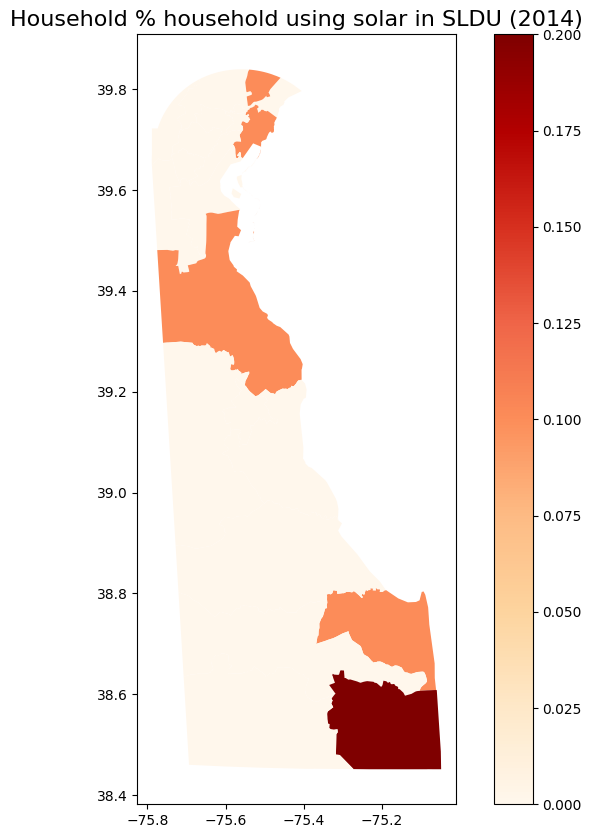

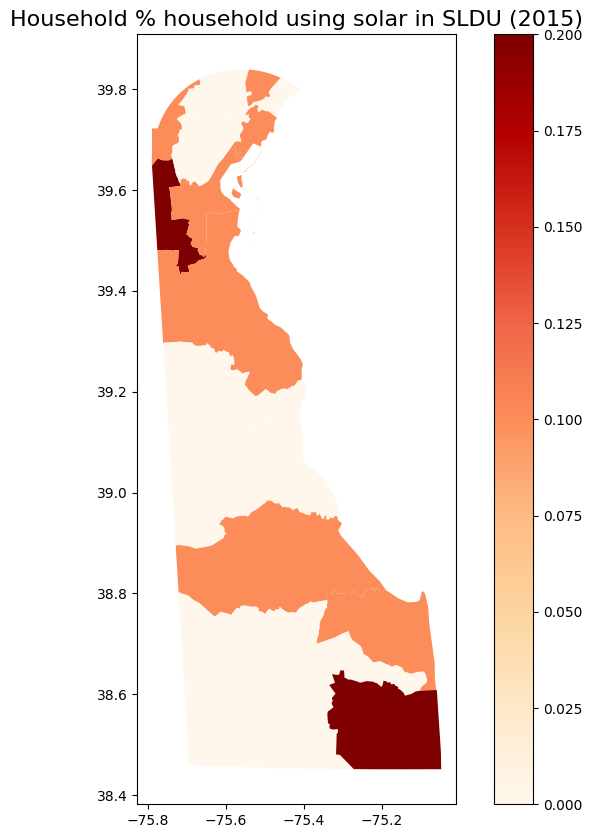

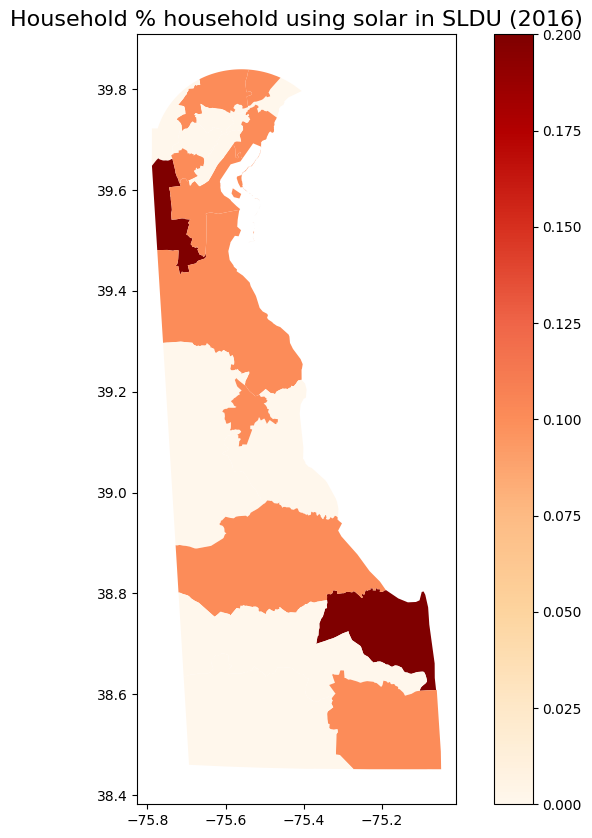

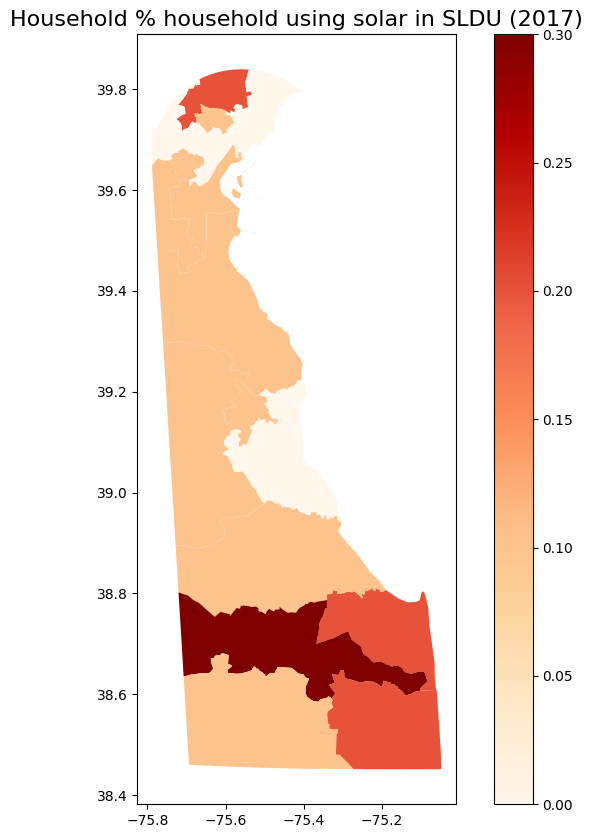

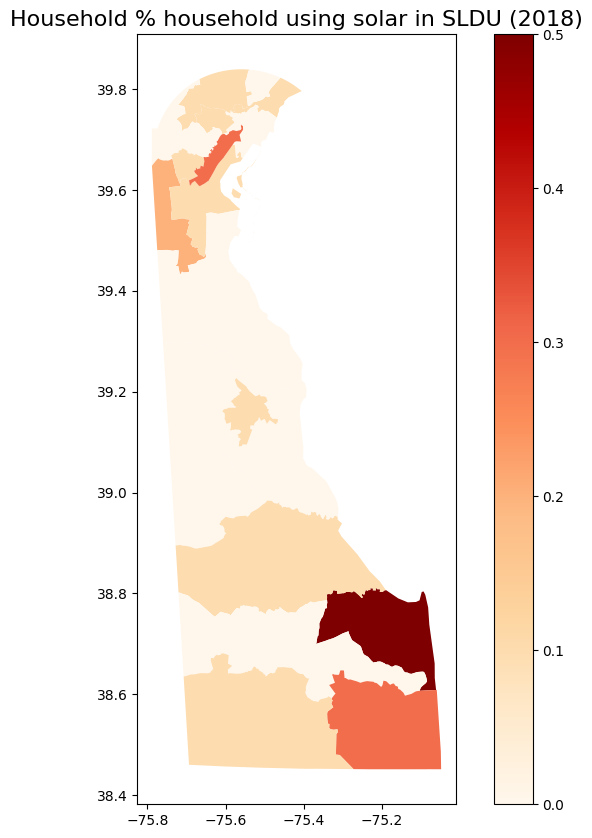

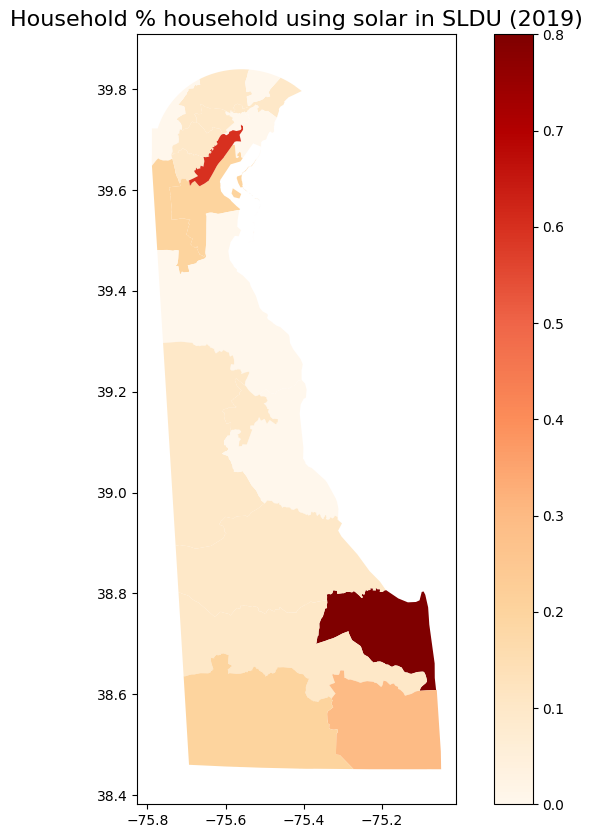

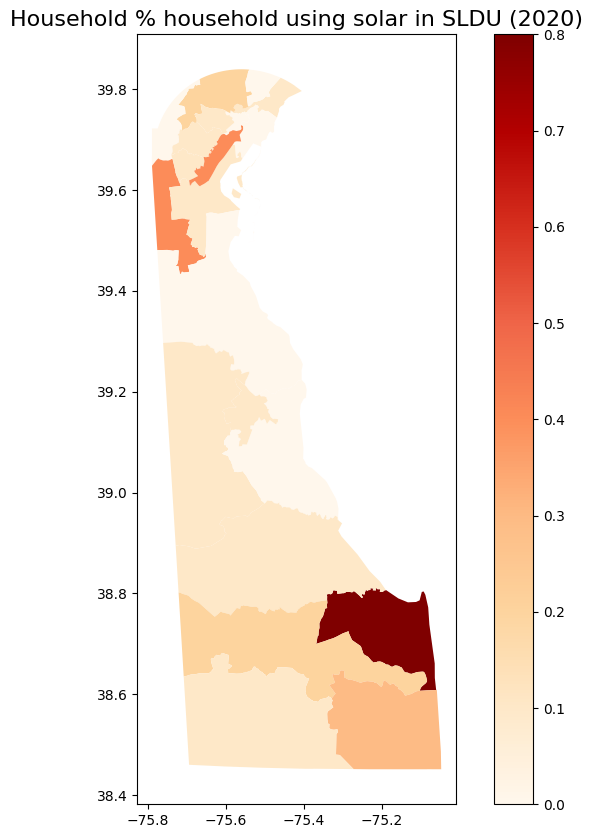

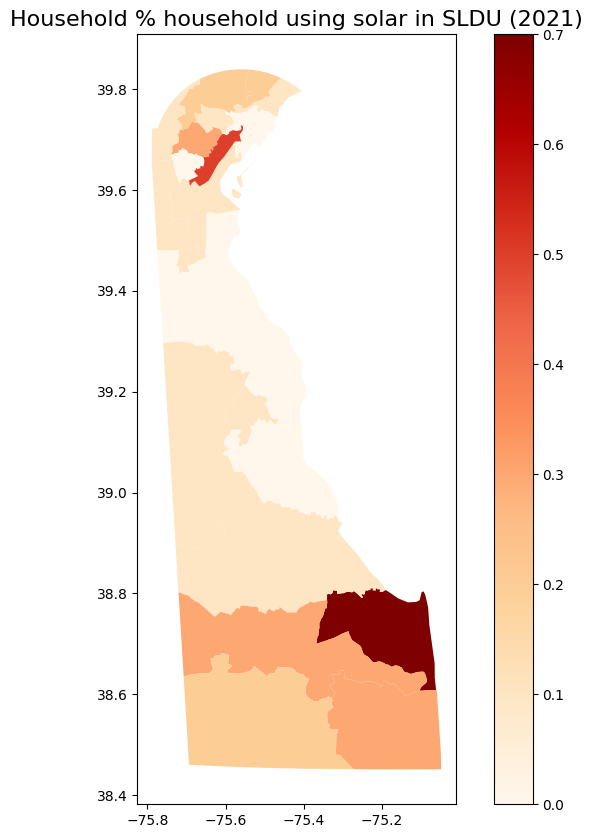

In [3]:
import requests
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load the Delaware dry land shapefile as a GeoDataFrame
USmap = gpd.read_file("/Users/kamran/Downloads/Shapefiles/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

usr_key = os.environ.get('CENSUS_API_KEY')

for i in range(2014,2022):
    year = str(i)
    
    host = 'https://api.census.gov/data'
    dataset_acronym = '/acs/acs5'
    g = '?get='
    variables = 'NAME,B01001_001E,B25040_001E,B25040_008E'
    location = '&for=state%20legislative%20district%20(upper%20chamber):*&in=state:10'

    # Put it all together in one f-string:
    query_url = f"{host}/{year}{dataset_acronym}{g}{variables}{location}&key={usr_key}"

    response = requests.get(query_url)

    # Create shapefile query URL
    shape_url = f"https://www2.census.gov/geo/tiger/TIGER{year}/SLDU/tl_{year}_10_sldu.zip"

    # Read the shapefile from the URL into a GeoPandas DataFrame
    sldu_gdf = gpd.read_file(shape_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:

        # Convert the JSON response to a list of lists (excluding the header)
        data = response.json()[1:]

        # Convert the list of lists into a DataFrame
        columns = response.json()[0]  # Use the first row as column names
        api_data_df = pd.DataFrame(data, columns=columns)
        api_data_df = api_data_df.astype({'B25040_001E':'int64','B25040_008E':'int64'}) #.apply(pd.to_numeric, errors='ignore')
        api_data_df['Percentage of households using solar energy'] = round((api_data_df['B25040_008E'] / api_data_df['B25040_001E']) * 100, 1)
#         print(api_data_df.head())

        # Spatial intersection to retain only the parts within the dry land of Delaware
        delaware_land_gdf = gpd.overlay(sldu_gdf, USmap, how='intersection')

        # Dissolve the GeoDataFrame based on the SLDUST column to eliminate duplicates
        delaware_land_gdf_dissolved = delaware_land_gdf.dissolve(by='SLDUST', aggfunc='first')

        # Merge the DataFrame with the GeoDataFrame based on the common key
        output_gdf = delaware_land_gdf_dissolved.merge(api_data_df, left_on="SLDUST", right_on="state legislative district (upper chamber)")
        output_gdf = output_gdf[['geometry','B01001_001E','Percentage of households using solar energy','state legislative district (upper chamber)']]
        output_gdf.rename(columns={'B01001_001E':'Estimated Population','state legislative district (upper chamber)':'District'},inplace=True)
        output_gdf = output_gdf.apply(pd.to_numeric, errors='ignore')
        print(output_gdf)

        # Save the merged GeoDataFrame as a GeoJSON file
        output_file = f"./DSHA_SLDU_all_years/SLDU_{year}.json"
        output_gdf.to_file(output_file, driver='GeoJSON')

        # Plot the merged GeoDataFrame with the added information from the DataFrame
        fig, ax = plt.subplots(figsize=(10, 10))
        output_gdf.plot(column="Percentage of households using solar energy", cmap="OrRd", legend=True, ax=ax)
        ax.set_title(f"Household % household using solar in SLDU ({year})", fontsize=16)
    else:
        print("Error: Unable to fetch data from the API.")

    plt.savefig(f"./DSHA_SLDU_all_years/sldu_{year}.png", dpi=300)
